# train lenet-5 on MNIST using fp32

In [2]:
import numpy as np
import tensorflow as tf
from dataset import load_mnist, load_cifar10
from tensorflow import keras
from keras import layers
from NeuralNetwork import QLeNet
import Activations
import FullyConnectedLayer 
import qvgg16


# load dataset
x_train, y_train, x_test, y_test = load_cifar10()



In [3]:
x = x_in = keras.layers.Input((32,32,3))

x = qvgg16.VGG_16(x_in, 10)

vgg = keras.Model(inputs=[x_in], outputs=[x])
vgg.summary()
vgg.compile(optimizer=keras.optimizers.Adam(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])
hist = vgg.fit(x_train, y_train, 256, 20, validation_data=(x_test, y_test))


(None, 10)
(50000, 10)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                      

# plot weight distribuiton

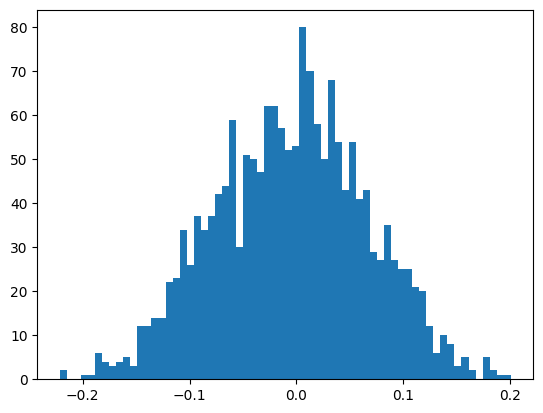

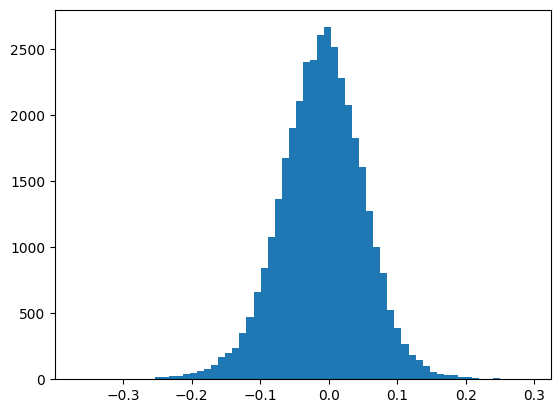

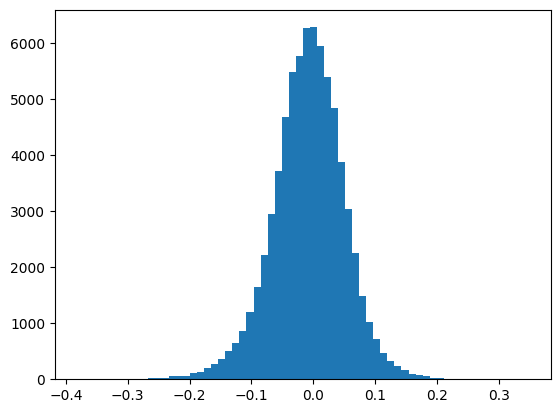

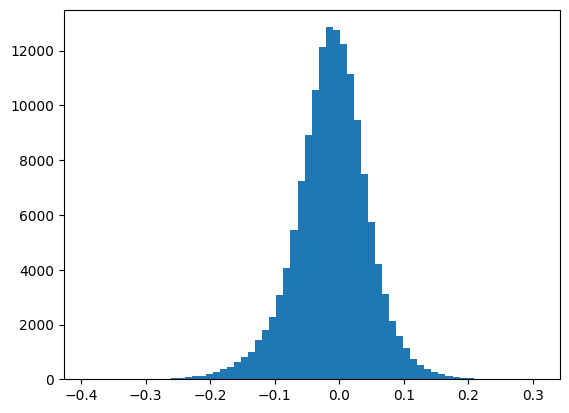

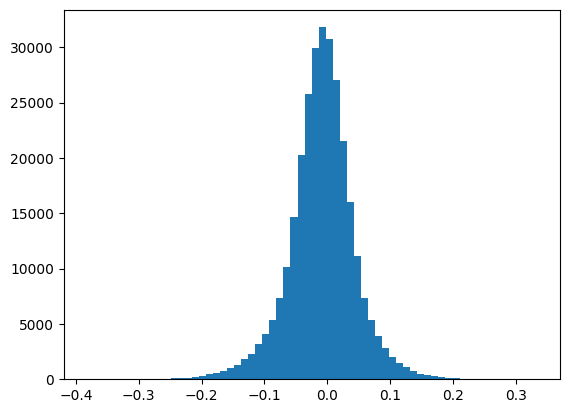

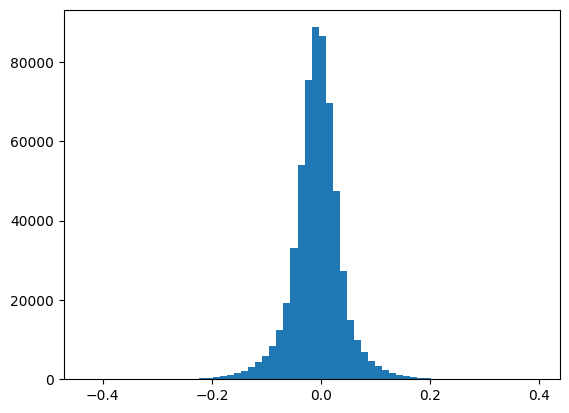

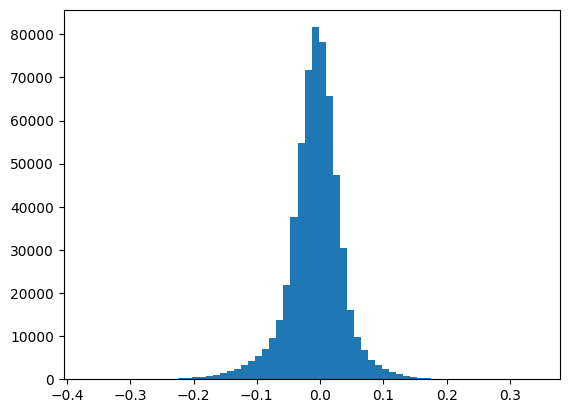

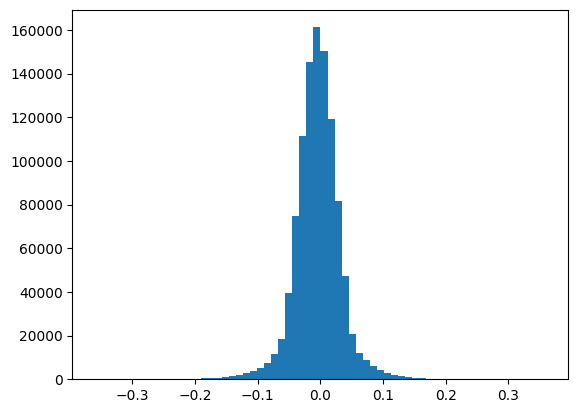

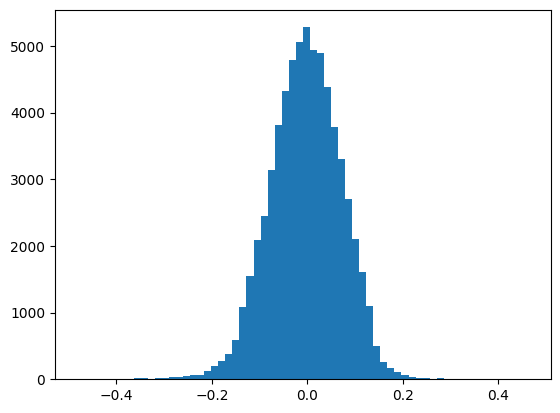

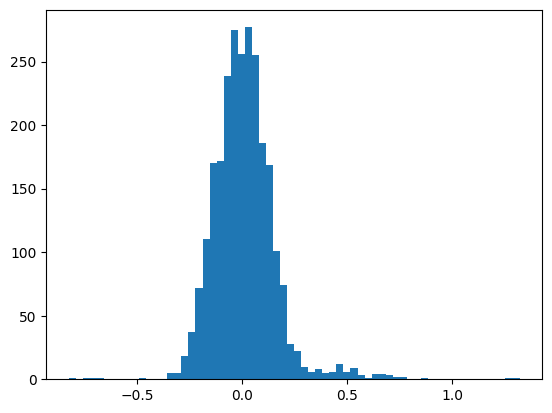

In [4]:
import matplotlib.pyplot as plt

for l in vgg.layers:
    if isinstance(l, keras.layers.Conv2D) or isinstance(l, keras.layers.Dense):
        w = l.weights[0].numpy()
        b = l.weights[1].numpy()

        plt.hist(np.ravel(w), bins=64)
        plt.show()


instanciating conv layer...


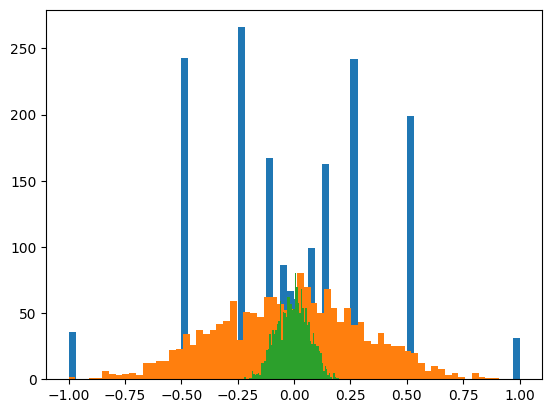

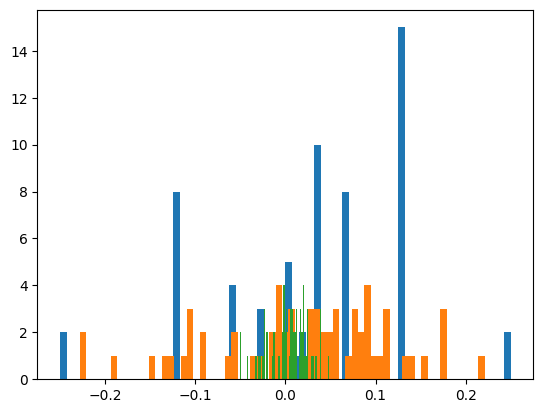

instanciating conv layer...


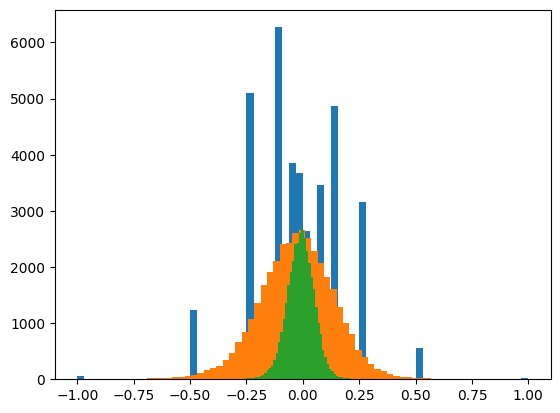

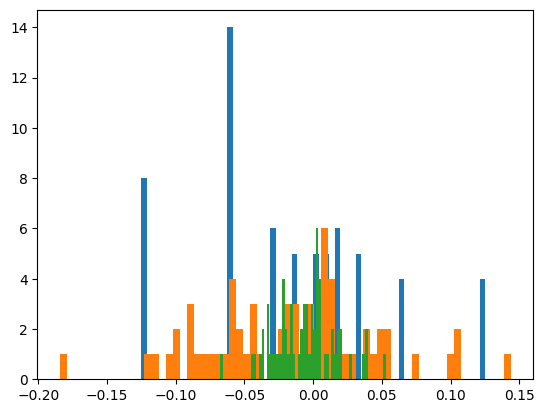

instanciating conv layer...


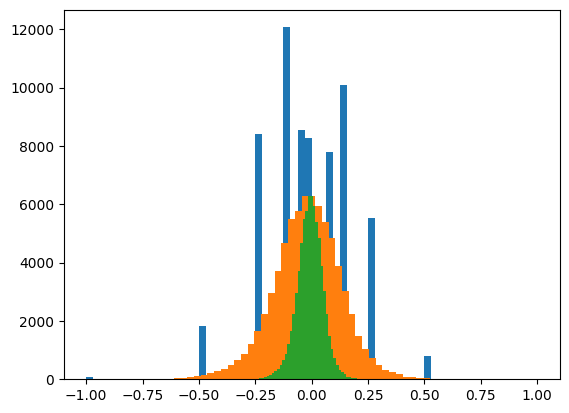

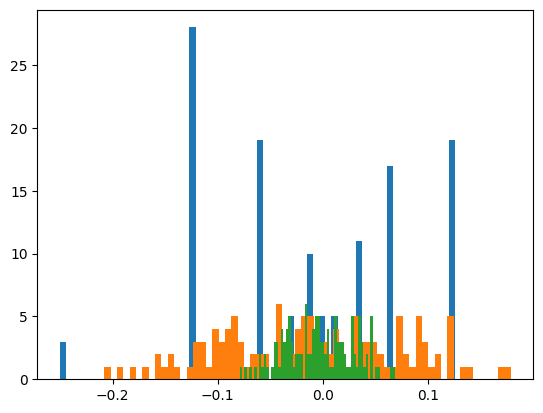

instanciating conv layer...


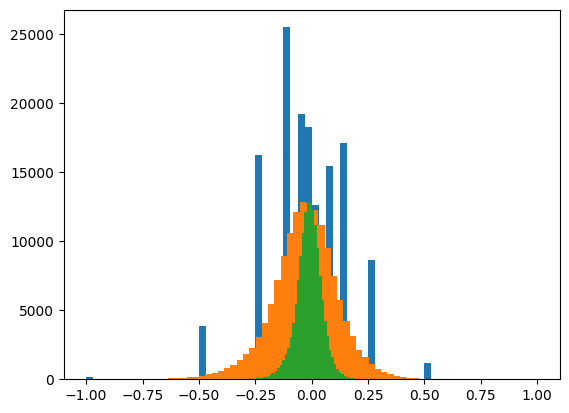

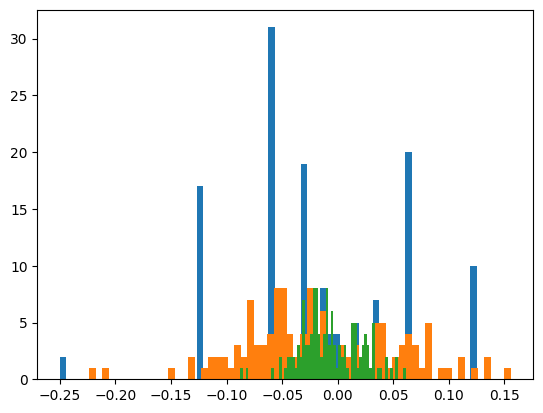

instanciating conv layer...


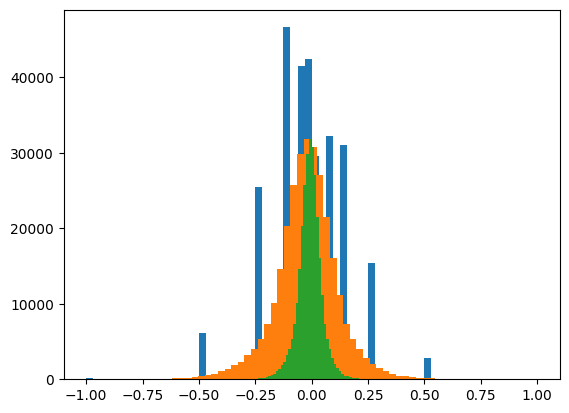

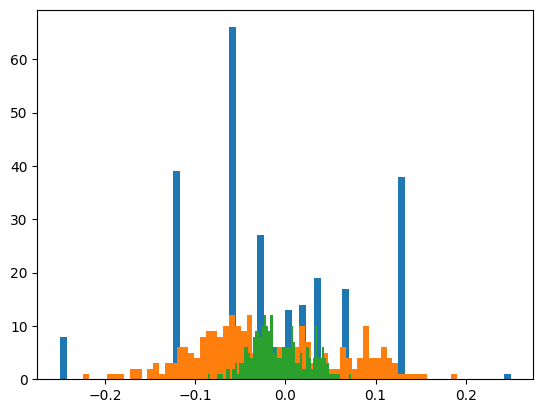

instanciating conv layer...


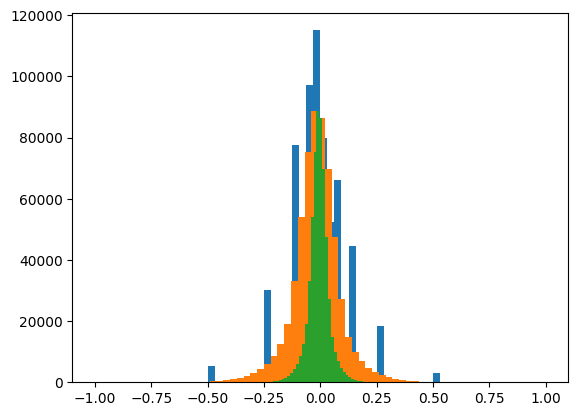

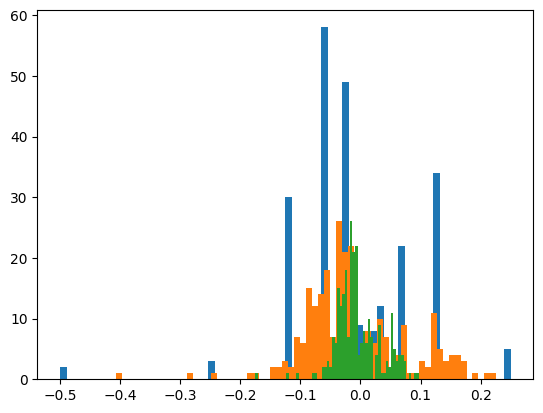

instanciating conv layer...


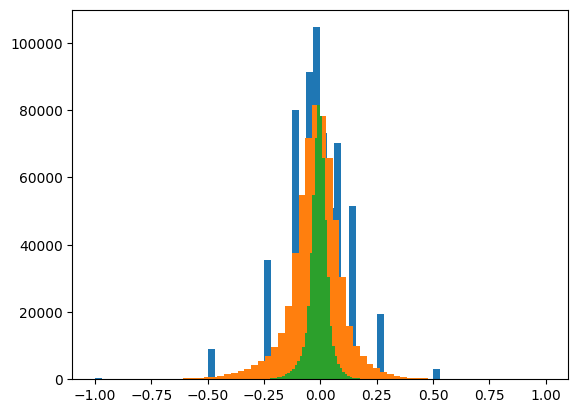

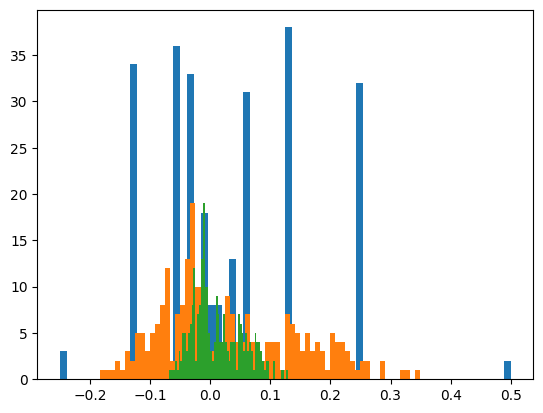

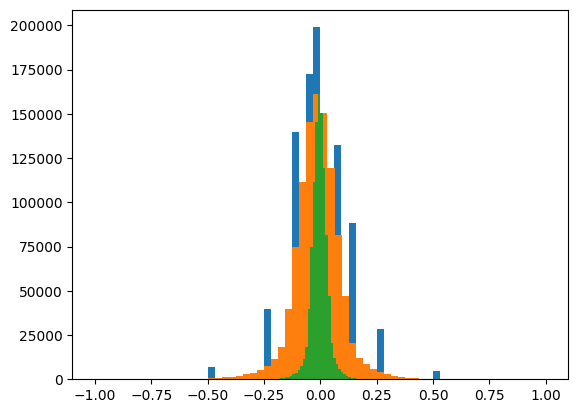

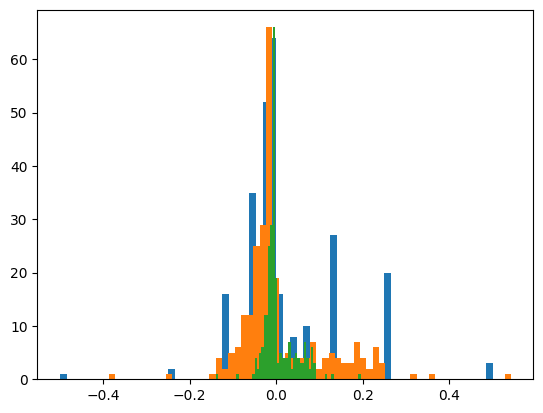

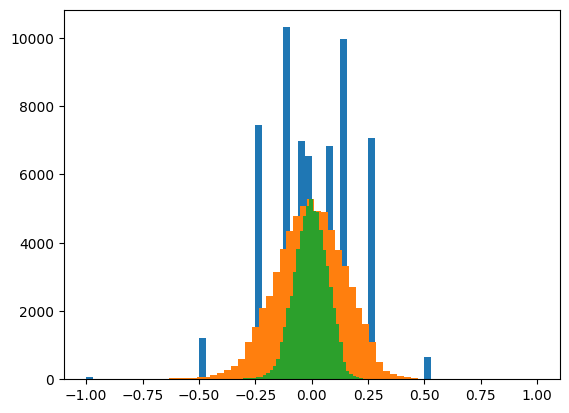

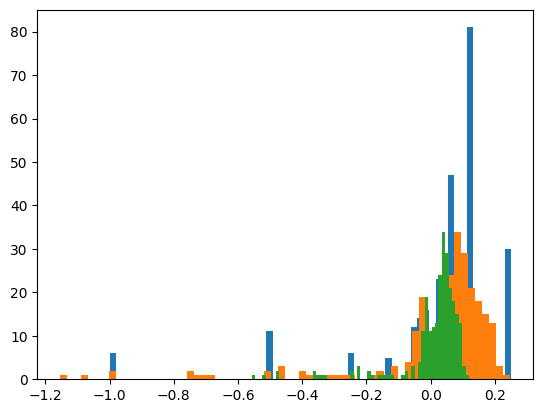

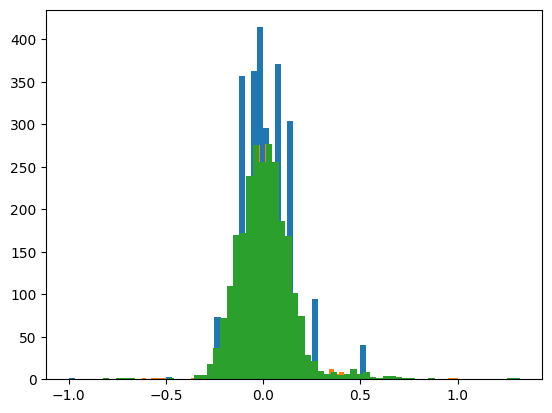

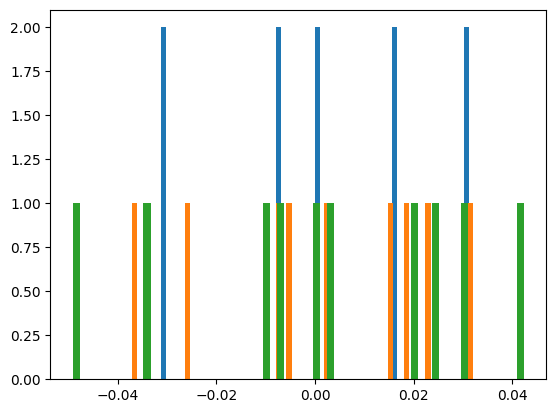

[<ConvLayer.QConvLayer object at 0x000001555350BEE0>, <Activations.QReLU object at 0x0000015554347940>, <ConvLayer.QConvLayer object at 0x00000155544FEC20>, <Activations.QReLU object at 0x0000015553EA5D80>, <ConvLayer.CustomMaxPool object at 0x0000015554487190>, <ConvLayer.QConvLayer object at 0x0000015553EAC550>, <Activations.QReLU object at 0x0000015553A06890>, <ConvLayer.QConvLayer object at 0x0000015553AE5360>, <Activations.QReLU object at 0x000001555499A680>, <ConvLayer.CustomMaxPool object at 0x00000155547DED40>, <ConvLayer.QConvLayer object at 0x00000155549BC9D0>, <Activations.QReLU object at 0x0000015555393310>, <ConvLayer.QConvLayer object at 0x0000015554A3CF40>, <Activations.QReLU object at 0x000001555390F460>, <ConvLayer.QConvLayer object at 0x00000155538F0610>, <Activations.QReLU object at 0x00000155544FFCA0>, <ConvLayer.CustomMaxPool object at 0x0000015554484C10>, <ConvLayer.CustomFlatten object at 0x0000015553EAE830>, <FullyConnectedLayer.QFullyConnectedLayerWithScale obj

In [6]:
# como vincular um modelo com o outro?
# mais vale criar um modelo do 0 com base no modelo q vier...
# o problema maior é criar cada camada
# a rede é só um array de camadas

import matplotlib.pyplot as plt
import quantizer

from ConvLayer import *

dn_layers = []
for l in vgg.layers:
    if isinstance(l, keras.layers.Conv2D):    
        print("instanciating conv layer...")
        l.weights[0].shape[0],l.weights[0].shape[1]

        w_shape = l.weights[0].shape
        nfilters = w_shape[3]
        kernel_size = w_shape[0]
        input_channels = w_shape[2]
        strides=[1,1,1,1] ### TODO: variable strides
        padding= l.padding

        # create QCONVLAYER
        qfc = QConvLayer(nfilters, kernel_size, input_channels, strides, padding)
        
        fpw = l.weights[0].numpy()        
        fpb  = l.weights[1].numpy()
        
        w_scale = np.max(np.abs(fpw))
        
        fpw_scaled = fpw / w_scale
        qw = quantizer.quantize(fpw_scaled, True, False)
        
        # atribui o peso quantizado
        qfc.qw = qw
        qfc.weights_scale = fpw_scaled
               

        plt.hist(np.ravel(qw), bins=64)
        plt.hist(np.ravel(fpw_scaled), bins=64)
        plt.hist(np.ravel(fpw), bins=64)
        plt.show()

        
        fpb_scaled = fpb / w_scale
        qb = quantizer.quantize(fpb_scaled, True, False)
        qfc.qb = qb
        plt.hist(np.ravel(qb), bins=64)
        plt.hist(np.ravel(fpb_scaled), bins=64)
        plt.hist(np.ravel(fpb), bins=64)
        plt.show()


        dn_layers.append(qfc)

    if isinstance(l, keras.layers.MaxPool2D):    
        print(l)
        dn_maxpool = CustomMaxPool(l.pool_size, l.strides)
        dn_layers.append(dn_maxpool)

    if isinstance(l, keras.layers.Flatten):    
        dn_layers.append(CustomFlatten(l.input_shape))
    if isinstance(l, keras.layers.Dense):        
        
        qfc = FullyConnectedLayer.QFullyConnectedLayerWithScale(l.weights[0].shape[0],l.weights[0].shape[1])
        
        fpw = l.weights[0].numpy()        
        fpb  = l.weights[1].numpy()
        
        w_scale = np.max(np.abs(fpw))
        
        fpw_scaled = fpw / w_scale
        qw = quantizer.quantize(fpw_scaled, True, False)
        
        # atribui o peso quantizado
        qfc.qw = qw
        qfc.weights_scale = fpw_scaled
               

        plt.hist(np.ravel(qw), bins=64)
        plt.hist(np.ravel(fpw_scaled), bins=64)
        plt.hist(np.ravel(fpw), bins=64)
        plt.show()

        
        fpb_scaled = fpb / w_scale
        qb = quantizer.quantize(fpb_scaled, True, False)
        qfc.qb = qb
        plt.hist(np.ravel(qb), bins=64)
        plt.hist(np.ravel(fpb_scaled), bins=64)
        plt.hist(np.ravel(fpb), bins=64)
        plt.show()


        dn_layers.append(qfc)


    if isinstance(l, keras.layers.ReLU):                
        dn_layers.append(Activations.QReLU())

print(dn_layers)




# deep nibble direct quantization

In [7]:
input_shape = x_train.shape[1:]

# Create and train the neural network
qlenet = QLeNet(input_shape=input_shape, output_size=y_train.shape[-1], batch_size=256)

mean_acc = 0
for i in range(100): 
    qlenet.load_layers_from_model(vgg)
    y_pred = qlenet.predict(x_test, 256)
        
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(y_pred == tf.argmax(y_test, axis=1), tf.float32))
    print(f"Accuracy: {accuracy * 100}%")

    mean_acc += accuracy
print(f"mean Accuracy: {mean_acc * 100/100}%")

Accuracy: 46.83000183105469%
Accuracy: 42.209999084472656%
Accuracy: 45.26000213623047%
Accuracy: 47.68000030517578%
Accuracy: 47.45000076293945%
Accuracy: 42.29999923706055%


In [ ]:
print(f"mean Accuracy: {mean_acc * 100/100}%")

# deep nibble finetunning

In [ ]:
input_shape = x_train.shape[1:]

# Create and train the neural network
qlenet = QLeNet(input_shape=input_shape, output_size=y_train.shape[-1], batch_size=256)


mean_acc = 0
for i in range(10):
    print(f"iteration {i} ... \n\n")
    
    qlenet.load_layers_from_model(lenet)
    

    # finetune the dnn
    qlenet.train(x_train, y_train, learning_rate=0.000010, num_epochs=1, x_val=x_test, y_val=y_test)
    
    
    # predict finetuned
    y_pred = qlenet.predict(x_test, 256)

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(y_pred == tf.argmax(y_test, axis=1), tf.float32))
    mean_acc += accuracy
    print(f"Accuracy: {accuracy * 100}%")

mean_acc /= 10
print(f"Accuracy: {mean_acc * 100}%")

# PO2 direct quantization

In [ ]:
from qkeras.utils import model_quantize, model_save_quantized_weights
from qkeras import *


# add one relu layer after input
x = x_in = keras.layers.Input((28,28,1))
x = keras.layers.ReLU()(x)
for l in lenet.layers[1:]:
    x = l(x)


lenet = keras.Model(inputs=[x_in], outputs=[x])
lenet.compile(optimizer=keras.optimizers.SGD(0.01), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])


quantizer_config = {        
    "QConv2D": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QActivation": { "relu": "quantized_relu_po2(4,1,use_stochastic_rounding=True)" },    
}

qmodel2 = model_quantize(lenet, quantizer_config, activation_bits=4, transfer_weights=True)    
qmodel2.summary()



In [ ]:

mean_acc = 0
for i in range(10):
    # quantize the mlp model
    qmodel2 = model_quantize(lenet, quantizer_config, activation_bits=4, transfer_weights=True)    

    # compile 
    qmodel2.compile(optimizer=keras.optimizers.SGD(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    
    # evaluate
    loss, acc = qmodel2.evaluate(x_test, y_test)

    mean_acc += acc


mean_acc /= 10
print(f"Accuracy: {mean_acc * 100}%")

# PO2 finetuning

In [ ]:

BATCH_SIZE = 256

mean_acc = 0
for i in range(10):
    # quantize the mlp model
    qmodel2 = model_quantize(lenet, quantizer_config, activation_bits=4, transfer_weights=True)    
    
    
    for l in qmodel2.layers:
        if isinstance(l, QConv2D):
            l.trainable = False


    # compile 
    qmodel2.compile(optimizer=keras.optimizers.SGD(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

    # train
    history = qmodel2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_data=(x_test, y_test), validation_freq=1)            

    # evaluate
    loss, acc = qmodel2.evaluate(x_test, y_test)

    mean_acc += acc


mean_acc /= 10
print(f"Accuracy: {mean_acc * 100}%")

# training last layers deep nibble from scratch

In [ ]:
input_shape = x_train.shape[1:]

# Create and train the neural network
qlenet = QLeNet(input_shape=input_shape, output_size=y_train.shape[-1], batch_size=256)


mean_acc = 0
for i in range(10):
    print(f"iteration {i} ... \n\n")
    
    # load pre-trained model
    qlenet.load_layers_from_model(lenet)
    qlenet.freeze_conv = True
    # restart
    qlenet.restart_fc_layers()
    

    # finetune the dnn
    qlenet.train(x_train, y_train, learning_rate=0.000010, num_epochs=1, x_val=x_test, y_val=y_test)
    qlenet.train(x_train, y_train, learning_rate=0.000100, num_epochs=10, x_val=x_test, y_val=y_test)
    qlenet.train(x_train, y_train, learning_rate=0.000010, num_epochs=1, x_val=x_test, y_val=y_test)
    
    
    # predict finetuned
    y_pred = qlenet.predict(x_test, 256)

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(y_pred == tf.argmax(y_test, axis=1), tf.float32))
    mean_acc += accuracy
    print(f"Accuracy: {accuracy * 100}%")

mean_acc /= 10
print(f"Accuracy: {mean_acc * 100}%")

# training last layer po2 from scratch

In [ ]:
from qkeras.utils import model_quantize, model_save_quantized_weights
from qkeras import *


# add one relu layer after input
x = x_in = keras.layers.Input((28,28,1))
x = keras.layers.ReLU()(x)
for l in lenet.layers[1:]:
    x = l(x)


lenet = keras.Model(inputs=[x_in], outputs=[x])
lenet.compile(optimizer=keras.optimizers.SGD(0.01), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])


quantizer_config = {        
    "QConv2D": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QActivation": { "relu": "quantized_relu_po2(4,1,use_stochastic_rounding=True)" },    
}

qmodel2 = model_quantize(lenet, quantizer_config, activation_bits=4, transfer_weights=True)    
qmodel2.summary()



In [ ]:

BATCH_SIZE = 256

mean_acc = 0
for i in range(10):
    print("iteratoin", i, "...\n")

    # quantize the mlp model
    qmodel2 = model_quantize(lenet, quantizer_config, activation_bits=4, transfer_weights=True)    
    
    # freeze and restart layer weights
    for l in qmodel2.layers:
        if isinstance(l, QConv2D):
            l.trainable = False
        if isinstance(l, QDense):            
            w = keras.initializers.GlorotNormal()(l.weights[0].shape)            
            b = tf.zeros_like(l.weights[1])            
            l.set_weights([w, b])


    # compile 
    qmodel2.compile(optimizer=keras.optimizers.SGD(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    # train
    history = qmodel2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_data=(x_test, y_test), validation_freq=1)                
    # compile 
    qmodel2.compile(optimizer=keras.optimizers.SGD(0.01), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    # train
    history = qmodel2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(x_test, y_test), validation_freq=1)                
    # compile 
    qmodel2.compile(optimizer=keras.optimizers.SGD(0.001), loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    # train
    history = qmodel2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_data=(x_test, y_test), validation_freq=1)                


    # evaluate
    loss, acc = qmodel2.evaluate(x_test, y_test)
    
    mean_acc += acc


mean_acc /= 10
print(f"Accuracy: {mean_acc * 100}%")